# Table of Content
0. Installation and import
1. load pypsa network
2. define DMoN model
3. Clustering process (what is done later on cluster with .py scripts): data preparation, normalization, traiing, apply trained model, reduce grid with pypsa; k-means
4. (Functions for analysis: grid visualizaiton, loss curves, ... . are used and adjusted in other notebook then)
5. Pypsa-optimization preparation: 3hourly resolution
6. Pypsa-optimization: trying it out, real one was done in cluster (see .py scripts)
7. Pypsa-Objective: rebuild to understand it

# 0) Installation and import

In [1]:
#%pip install torch_geometric
#%pip install torch
#%pip install glasbey
import pypsa
import torch
import utils
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import os.path as osp
from torch_geometric.nn import DMoNPooling, GCNConv
from torch_geometric.utils import to_dense_adj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # For map projections
import warnings
import itertools
import pandas as pd
from IPython.display import Image, display
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import glasbey
import random
import gurobipy
import gc
import torch.nn as nn
import torch.nn.init as init
import utils_variance



warnings.filterwarnings("ignore", category=FutureWarning, module="pypsa")
warnings.filterwarnings(
    "ignore",
    message="facecolor will have no effect as it has been defined as 'never'",
    category=UserWarning,
)

# 1) Load network

In [2]:
path = "/Users/ninakirsch/Desktop/my_files_for_github/elec_s.nc"
n = pypsa.Network(path)
n.calculate_dependent_values() # Calculate per unit impedances and append voltages to lines and shunt impedances

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units


# 2) Define the DMoN for clustering

In [3]:
# Hyperparameters: for testing others (as initially lr 0.001, just chnage them here)
LEARNING_RATE = 0.0001
EPOCHS = 150
HIDDEN_UNITS = 512

In [4]:
class DMoN(torch.nn.Module):
    def __init__(self, in_channels, clusters, hidden_channels, seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        np.random.seed(seed)
        
        super().__init__()
        # graph convolutional layers
        self.conv1 = GCNConv(in_channels, hidden_channels, add_self_loops=True, normalize=True) # weight_initializer='glorot' is implemented in the GCNConv class
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops=True, normalize=True) #  weight_initializer='glorot' is implemented in the GCNConv class
        
        # pooling layer
        self.pool = DMoNPooling(hidden_channels, clusters)

    def forward(self, x, edge_index, edge_attributes):
        x = x.to(dtype=torch.float)
        edge_attributes = edge_attributes.to(dtype=torch.float)
        
        # forward pass GCN layers
        x = self.conv1(x, edge_index, edge_weight=edge_attributes).relu()
        x = self.conv2(x, edge_index, edge_weight=edge_attributes).relu()
        
        # dense adjacency matrix
        adj = to_dense_adj(edge_index, edge_attr=edge_attributes).squeeze()
        adj = adj.to(x.dtype)
        
        # pooling layer
        cluster_assignment, pooled_node_feat, adj, spectral_loss, ortho_loss, cluster_loss = self.pool(x, adj)
        
        # scaling as in DMoN paper
        loss = 100 * (spectral_loss + cluster_loss)
        return cluster_assignment, loss, 100*spectral_loss, 100*cluster_loss
       


# 3) Clustering according to different features 

## (3.0 explanation: Normalization of data)
- here it is explained and showed what will be done in 4) Clustering

In [55]:
# extract data for selected features 
carriers = ["onwind",'offwind-ac','offwind-dc', 'solar'] 
include_time = True

# example for extracting data
data, adj, mapping, feature_names = utils.pypsa_to_pyg(n, carriers=carriers, verbose=True, include_time=include_time, time_resolution="2h")

# adjecency matrix (unweighted), weights are in edge attributes + edge index
#print(adj[0:2, 0:4])

# normalization 
print(data.x[0:2, 0:4]) # before
scaler = MinMaxScaler()
data.x[:, 0:2] = torch.from_numpy(scaler.fit_transform(data.x[:, 0:2]))
data.x = data.x.to(torch.float32)

print(data.x[0:2, 0:4], "Normalizaiton of coordinates data (first 2 values) but not the rest") # check if normalization worked
print("different features values: ", len(set(data.x[0,:]))) # check if all features are included and no duplicates


# check adj and edge info and if is symmetric
print(adj[0], "Adjacency matrix (first 2 values): ")
# check if adj is symmetric
print("Is adj symmetric? ", torch.all(torch.eq(adj, adj.T))) # check if adj is
print(data.edge_attr[:2])
print(data.edge_index[:2])

2h
torch.Size([2, 972])
tensor([[  0,   0,   1,  ..., 338, 338, 338],
        [242, 136,  98,  ...,  26, 276, 237]])

 Data(edge_index=[2, 972], x=[339, 17522], edge_attr=[972, 1])
Adj size:  torch.Size([339, 339]) 

tensor([[ 8.3070, 49.4230,  0.5681,  0.6540],
        [ 7.9939, 51.7687,  0.9837,  0.9794]])
tensor([[0.2392, 0.2570, 0.5681, 0.6540],
        [0.2006, 0.5908, 0.9837, 0.9794]]) Normalizaiton of coordinates data (first 2 values) but not the rest
different features values:  17522
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

## 3.1) Clustering process

In [5]:
# 1) Data Preparation for Different Configurations (here it is not with variance possible, that is in the python scripts and with utils_variance.py)
def prepare_data(n, carriers, time_resolution, include_time):
    """
    prepares data and features for a carrier configurations
    normalizes coordinates and converts the PyPSA network to a PyG object
    
    Args:
        n (pypsa.Network): pypsa network
        carriers: List of carrier used for the clustering
        time_resolution: Time resolution which should be applied on the data (e.g. "2h")
        include_time: Boolean value to include time series data or not
    
    Returns:
        data: The PyG data object
        adj: The adjacency matrix
        mapping: The mapping of nodes to buses
        feature_names: The feature names
    """

    data, adj, mapping, feature_names = utils.pypsa_to_pyg(n, carriers, verbose=True, include_time=include_time, time_resolution=time_resolution)
    scaler = MinMaxScaler()
    data.x[:, 0:2] = torch.from_numpy(scaler.fit_transform(data.x[:, 0:2]))  # Normalize coordinates so that they are in the same range as the other features [0,1]
    data.x = data.x.to(torch.float32)

    return data, adj, mapping, feature_names

In [6]:
# 2) Training the DMoN Model for Different Configurations
def train_dmon_model(data, carriers, include_time, num_clusters, seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multiple GPUs
    np.random.seed(seed)  # for numpy, if used
    """
    Train DMoN model with given configuration
    
    Args:
        data: The input data for training
        carriers (list): List of carriers for the configuration
        include_time (bool): Flag to include time series data
        num_clusters (int): Number of target lusters for the model
        seed (int): Random seed for reproducibility

    Returns:
        dict: dictionary containing the results of training process
    """
    # Initialize and reset model parameters for each configuration
    hidden_units = HIDDEN_UNITS
    print("Number of hidden units: ", hidden_units)
    
    model = DMoN(in_channels=data.x.shape[1],  # Number of input features
            clusters=num_clusters,  # Number of clusters
            hidden_channels=hidden_units,  # Hidden units  
            seed=seed
            )
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    
    # Initialize lists for logging
    epoch_losses = []
    spectral_losses = []
    cluster_losses = []
    #cluster_assignment_softmax = []
    
    for epoch in range(EPOCHS):
        model.train()
        optimizer.zero_grad()
        cluster_assignment_softmax, loss, spectral_loss, cluster_loss = model(data.x, data.edge_index, data.edge_attr)
        loss.backward()
        optimizer.step()
        #cluster_assignment_softmax, loss, spectral_loss, cluster_loss = model(data.x, data.edge_index, data.edge_attr) is the results of "testing"
        
        # Log losses
        epoch_losses.append(loss.item())
        spectral_losses.append(spectral_loss.item())
        cluster_losses.append(cluster_loss.item())
        #cluster_assignment_softmax.append(cluster_assignment_softmax.item())
        
        # Log every 100 epochs
        if (epoch + 1) % 100 == 0 or epoch == 0:  
            print(f"  Epoch {epoch + 1}/{EPOCHS}: Loss={loss.item():.4f}, Spectral Loss={spectral_loss.item():.4f}, Cluster Loss={cluster_loss.item():.4f}")
    
    return {
        # needed as information
        "carriers": carriers,
        "include_time": include_time,
        "data": data, # extracetd data from beginning
        "model": model, # trained model
        
        # hyperparameters 
        "clusters": num_clusters,
        "hidden_units": hidden_units,
        
        # results
        "cluster_assignment_softmax": cluster_assignment_softmax,
        "epoch_losses": epoch_losses,  
        "spectral_losses": spectral_losses,
        "cluster_losses": cluster_losses
    }


In [7]:
# 3) test the model (we could also just take results of last training epoch, but usually we would set the model to evaluation mode, so we do it here
# and take the trained model after the last epoch and last training step)
def test_model(n, data, mapping, model, carriers, include_time, num_clusters):
        """
        Use trained model to predict the cluster assignment and give loss
        Args:
                n (pypsa.Network): PyPSA network 
                data: input data for training
                mapping (dict): Mapping of nodes to bus IDs
                model: trained model
                carriers (list): List of carriers for the configuration
                include_time (bool): include time series data?
                num_clusters (int): target clusters for the model
        Returns:
        dict: dictionary containing results of the testing 
        """
        model.eval() 
        print("Model in eval mode:", not model.training)
        
        # take the trained model and predict the cluster assignments
        cluster_assignment_softmax, loss, spectral_loss, cluster_loss = model(data.x, data.edge_index, data.edge_attr)
      
        # Remove batch dimension and convert to busmap for PyPSA
        cluster_assignment_softmax = cluster_assignment_softmax.squeeze(0)
        busmap = utils.clusters_to_busmap(cluster_assignment_softmax, mapping)

        # Cluster the original network by the obtained busmap
        nc = n.cluster.cluster_by_busmap(busmap)
      
        print("Loss: ", loss.item())
        print("Spectral Loss: ", spectral_loss.item())
        print("Cluster Loss: ", cluster_loss.item())
      
        tested_model = {
                "model": model,
                "loss": loss.item(),
                "spectral_loss": spectral_loss.item(),
                "cluster_loss": cluster_loss.item(),
              
                "busmap": busmap,
                "cluster_assignment_softmax": cluster_assignment_softmax,
              
                # needed for plotting
                "carriers": carriers,
                "include_time": include_time,
                "clusters": num_clusters,
                "mapping": mapping
                }
        n_c = { # for data transfer it has to be separate
                "nc" : nc,
        }
        return tested_model, n_c

In [8]:
# 4) Main Function: Data Preparation and Model Training for list of feature Configurations (2h capacity factors for differnt generators and combinations)
def main(n, carriers, include_time, time_resolution, num_clusters, seed):
    """
    trains DMoN model with a specific configurations and returns the model and results after training
    """
    # Prepare data 
    print(carriers)
    print(time_resolution)
    print(num_clusters)
    print(seed)
    data, adj, mapping, feature_names = prepare_data(n, carriers, time_resolution, include_time, )
    
    # Train the DMoN model for this configuration
    trained_model = train_dmon_model(data, carriers, include_time, num_clusters, seed)

    return trained_model, mapping

In [9]:
# 5) Run Experiment for Different Configurations
def run_experiment(n, carrier_configs, time_resolution, num_clusters, seed):
    # Train models for each configuration
    training_results = {}
    mappings = {}
    for key, carriers in carrier_configs.items():
        
        if key == 'only_coordinates':
            training_results[key], mappings[key] = main(n, carriers, False, time_resolution, num_clusters, seed)
        else:
            training_results[key], mappings[key] = main(n, carriers, True, time_resolution, num_clusters, seed)
    
    # Test the trained models
    testing_results = {}
    testing_results_nc = {}
    for key, train_result in training_results.items():
        tested_model, nc = test_model(
            n, 
            train_result['data'], 
            mappings[key], 
            train_result['model'],
            train_result['carriers'], 
            train_result['include_time'], 
            train_result['clusters'], 
        )
        testing_results[key] = tested_model
        testing_results_nc[key] = nc

    return training_results, testing_results, testing_results_nc

In [11]:
# Run the main function
path = "/Users/ninakirsch/Desktop/my_files_for_github/elec_s.nc"
n = pypsa.Network(path)
n.calculate_dependent_values() 

# example call 
carrier_configs = {
        "only_coordinates": [],
        "onwind": ["onwind"],
        "offwind_ac": ["offwind-ac"],
        "offwind_dc": ["offwind-dc"],
        "solar": ["solar"],
        "all": ["onwind", "offwind-ac", "offwind-dc", "solar"]
    }

# if you dont want the chosen hyperparameters, change here to investigate e.g. a higher learning rate
EPOCHS = 2000
#LEARNING_RATE = 0.0001
carrier_configs = {"all": ["onwind", "offwind-ac", "offwind-dc", "solar"]}

training_results100, testing_results100, testing_results_nc100 = run_experiment(n, carrier_configs = carrier_configs, time_resolution="2h", num_clusters=100, seed=10)
#training_results100["all"]["cluster_assignment_softmax"].squeeze(0).argmax(dim=1) == testing_results100["all"]["cluster_assignment_softmax"].squeeze(0).argmax(dim=1)

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units


['onwind', 'offwind-ac', 'offwind-dc', 'solar']
2h
100
10
2h
torch.Size([2, 972])
tensor([[  0,   0,   1,  ..., 338, 338, 338],
        [242, 136,  98,  ...,  26, 276, 237]])

 Data(edge_index=[2, 972], x=[339, 17522], edge_attr=[972, 1])
Adj size:  torch.Size([339, 339]) 

Number of hidden units:  512
  Epoch 1/2000: Loss=0.2138, Spectral Loss=-0.0010, Cluster Loss=0.2149
  Epoch 100/2000: Loss=-4.5583, Spectral Loss=-5.9142, Cluster Loss=1.3559
  Epoch 200/2000: Loss=-11.0416, Spectral Loss=-12.0295, Cluster Loss=0.9880
  Epoch 300/2000: Loss=-25.2766, Spectral Loss=-28.7384, Cluster Loss=3.4618
  Epoch 400/2000: Loss=-43.3757, Spectral Loss=-48.5703, Cluster Loss=5.1947
  Epoch 500/2000: Loss=-58.8726, Spectral Loss=-67.9316, Cluster Loss=9.0591
  Epoch 600/2000: Loss=-66.3015, Spectral Loss=-73.7818, Cluster Loss=7.4804
  Epoch 700/2000: Loss=-68.3632, Spectral Loss=-75.7441, Cluster Loss=7.3809
  Epoch 800/2000: Loss=-69.2983, Spectral Loss=-76.5270, Cluster Loss=7.2287
  Epoch 90

/opt/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/pypsa/clustering/spatial.py:416: RuntimeWarning: divide by zero encountered in scalar divide
  static_strategies[col] = lambda x: 1.0 / x.sum()


Loss:  -71.33491516113281
Spectral Loss:  -77.54967498779297
Cluster Loss:  6.214761734008789


In [ ]:
training_results200, testing_results200, testing_results_nc200 = run_experiment(n, carrier_configs = carrier_configs, time_resolution="2h", num_clusters=200, seed=10)

In [ ]:
training_results16, testing_results16, testing_results_nc16 = run_experiment(n, carrier_configs = carrier_configs, time_resolution="2h", num_clusters=16, seed=10)

## 3.2) how to do k-means clustering

In [342]:
n = pypsa.Network(path)
bus_weightings = pd.Series(1, index=n.buses.index)
n_average = n.cluster.cluster_spatially_by_kmeans(n_clusters = 100, bus_weightings=bus_weightings) # unweighted clustering: bus weightings are all 1

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units


# 4) Functions for analysing results (can be ignored here, are used in other notebook)
## 4.1) Plot loss curves of different clustering configurations

In [13]:
def plot_loss_curves(results, colormap=plt.cm.tab20):
    """
    plots the loss curves of different experiments based on the provided results
    
    Parameters:
    - results (list of dicts): list where each element is a dictionary containing the experiment results.
      each dictionary should have following keys:
        - epoch_losses: list of loss values per epoch.
        - carriers
        - include_time

    """
    num_colors = len(results)

    # Generate an array of colors from the colormap
    colors = [colormap(i / num_colors) for i in range(num_colors)]
    
    # Create a new figure with specified size
    fig = plt.figure(figsize=(12, 8))

    # Loop through each experiment and plot its loss curve with a unique color
    idx = 0
    for key, result in results.items():
        epoch_losses = result["epoch_losses"]
        label = f"Features: {' '.join(result['carriers'])}, Time series data = {result['include_time']}"

        # Select a color from the colormap
        color = colors[idx % len(colors)]
        
        # Plot the loss curve for the current experiment
        plt.plot(range(len(epoch_losses)), epoch_losses, label=label, color=color)
        idx += 1

    # Customize plot
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Loss Curves for Clustering Accoring to Different Features", fontsize=16)
    plt.legend(title="Features", fontsize=10, loc='upper right')
    plt.grid(True)  # Enable grid for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping

    # Show the plot
    plt.show()
  

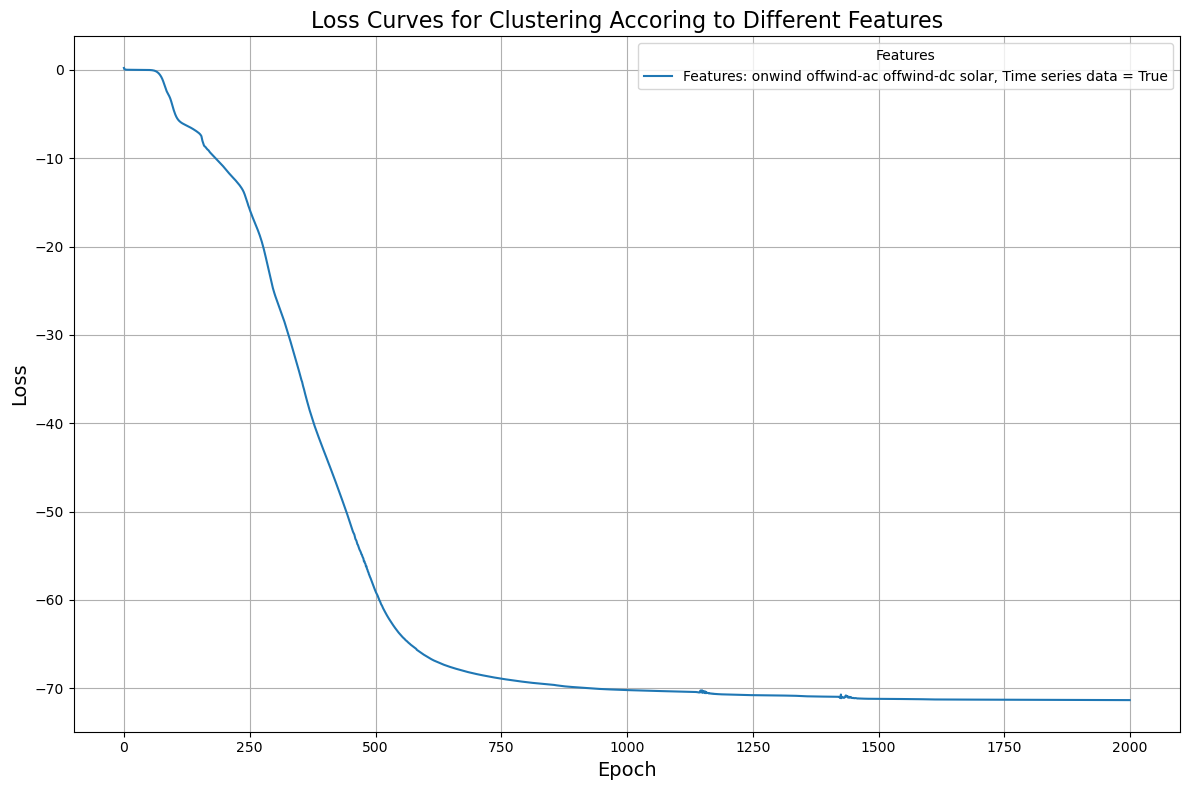

In [14]:
#plot_loss_curves(training_results16)
plot_loss_curves(training_results100)
#plot_loss_curves(training_results200)

![](plots_folder/loss_cuve_xn-norm_final_5days.png)

## 4.2) Plot busmaps before and after clustering

In [73]:
def plot_clustered_grid(results, n_cl):
    """
    Plots the electric grid of Germany for each experiment in the results
    three plots for each experiment:
    1. Original grid (unclustered)
    2. Cluster assignment based on softmax probabilities
    3. Clustered grid (after clustering with updated bus colors)
    
    Parameters:
    - results (list of dicts): each with keys:
      - softmax_probs
      - learning_rate, epochs, hidden_units, clusters: Hyperparameters for the experiment.
      - nc: Network after clustering.
      - include_time
      - carriers
    - nc: network object after clustering.
    
    """
    np.random.seed(203)  # For consistent colors across runs
    
    # Create subplots for each experiment
    fig, axes = plt.subplots(len(results), 3, figsize=(15, 5 * len(results)), subplot_kw={"projection": ccrs.PlateCarree()})

    # Loop through each experiment in the results
    i = 0
    for key, result in results.items():
      print(key)
      cluster_assignment_softmax = result["cluster_assignment_softmax"]  # Softmax output for clustering
        
      # 1st Plot: Original Grid (Unclustered)
      n.plot(ax=axes[i, 0], boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
              title="Electric grid of Germany", geomap=True, color_geomap=True, 
              branch_components=["Line", "Link"], line_colors="red", link_colors="green")
        
      # 2nd Plot: Cluster Assignment based on softmax probabilities
      # Assign clusters based on softmax outputs
      cluster_assignment = cluster_assignment_softmax.argmax(dim=1).numpy()
        
      # Generate a color palette for the clusters
      unique_clusters = np.unique(cluster_assignment)
      glasbey_palette = glasbey.create_palette(palette_size=len(unique_clusters))
      random.shuffle(glasbey_palette)  # Shuffle to ensure distinguishable colors for nearby clusters
        
      # Map each cluster to a unique color
      bus_colors = {cluster: glasbey_palette[i % len(glasbey_palette)] for i, cluster in enumerate(unique_clusters)}
      n.buses['color'] = [bus_colors[cluster] for cluster in cluster_assignment]
        
      # Plot buses with colors based on the cluster assignment
      n.plot(ax=axes[i, 1], boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
               title="Colours according to assigned cluster", geomap=True, color_geomap=True, 
               branch_components=["Line", "Link"], line_colors="red", link_colors="green", 
               bus_colors=n.buses['color'])
        
      axes[i, 1].text(0.5, -0.03,
                      f"Learning Rate: {result['learning_rate']}, Epochs: {result['epochs']}, "
                      f"Hidden Units: {result['hidden_units']}, Clusters: {result['clusters']}", 
                      transform=axes[i, 1].transAxes, ha='center', va='top', fontsize=7)
        
      # 3rd Plot: Clustered Grid (After Clustering)
      nc = n_cl[key]["nc"]  # Network after clustering
        
      # Reassign bus colors based on clustering result for `nc`
      nc.buses['color'] = [bus_colors[int(cluster)] for cluster in nc.buses.index]
        
      # Plot the clustered grid
      nc.plot(ax=axes[i, 2], boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
              title=f"Time series data = {result['include_time']}, \n Coordinates and features: {' '.join(result['carriers'])} ", 
              geomap=True, color_geomap=True, branch_components=["Line", "Link"], line_colors="red", link_colors="green", 
              bus_colors=nc.buses['color'])
        
      axes[i, 2].text(0.5, -0.03, 
                      f"{len(unique_clusters)} clusters",
                      transform=axes[i, 2].transAxes, ha='center', va='top', fontsize=7)
        
        # Clean up by removing the 'color' column to avoid conflicts in future iterations
      n.buses = n.buses.drop(columns=['color'])
      nc.buses = nc.buses.drop(columns=['color'])
      i += 1

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

## 4.3) Modularity and loss plots

In [40]:
from collections import defaultdict

# calculate modularity for a single experiment
def calculate_modularity(n, data, busmap, mapping):
    """
    calculates the modularity of the clustered network based on the cluster assignment
    """
    # convert cluster assignment to a dictionary
    cluster_dict = busmap.to_dict()
    
    # create a graph from the network
    G = nx.Graph()
    for (u, v), w in zip(data.edge_index.t().tolist(), data.edge_attr):
        G.add_edge(u, v, weight=w)
    
    # convert cluster assignment to a partition (list of lists), use mapping to convert node names
    partition = defaultdict(list)
    for node, cluster in cluster_dict.items():
        partition[cluster].append(int(mapping[node]))
    
    
    # convert partition to a list of node lists
    partition = list(partition.values())
    
    # Calculate modularity
    modularity = nx.algorithms.community.modularity(G, partition, weight="weight")
    return modularity[0]

#calculate_modularity(n, training_results["only_coordinates"]["data"], testing_results["only_coordinates"]["busmap"], testing_results["only_coordinates"]["mapping"])
#calculate_modularity(n, training_results["onwind"]["data"], testing_results["onwind"]["busmap"], testing_results["onwind"]["mapping"])

In [38]:
# calculate modularity and get spectral modularity and cluster loss
def all_modularities(n, training_results, testing_results):
    """
    Calculates the modularity, spectral modularity, and cluster loss for each config
    """
    results = {}
    for key, result in training_results.items():
        data = result["data"]
        busmap = testing_results[key]["busmap"]
        mapping = testing_results[key]["mapping"]
        
        modularity = calculate_modularity(n, data, busmap, mapping)
        spectral_modularity = testing_results[key]["spectral_loss"] / -100
        cluster_loss = testing_results[key]["cluster_loss"] / 100
        
        results[key] = {
            "modularity": modularity,
            "spectral_modularity": spectral_modularity,
            "cluster_loss": cluster_loss
        }
    
    return results

In [ ]:
# plot the modularity and cluster loss in one plot 
def plot_modularity_cluster_loss(all_modularities):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the spectral modularity
    x = np.arange(len(all_modularities))
    ax.plot(x, [result["modularity"] for result in all_modularities.values()], label="Modularity", marker='o')
    ax.plot(x, [result["spectral_modularity"] for result in all_modularities.values()], label="Spectral Modularity", marker='o')
    ax.plot(x, [result["cluster_loss"] for result in all_modularities.values()], label="Cluster Loss", marker='o')
    
    # Customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(all_modularities.keys(), rotation=45, ha='right')
    ax.set_xlabel("Features", fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.set_title("Modularity, Spectral Modularity, and Cluster Loss", fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


## 4.4) Nodes per cluster

In [ ]:
# plot how many nodes per cluster 
def plot_nodes_per_cluster(test_dict_one_exp, n, title):
    """
    Plots the number of nodes per cluster for each experiment.
    
    Parameters:
    - training_dict_one_exp (dict): dictionary containing the training results for one experiment.
    - n (pypsa.Network)
    """
    # Create a new figure with specified size
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # perfect average number of nodes per cluster
    num_cl = test_dict_one_exp["clusters"]
    avg_nodes_per_cluster = n.buses.shape[0] / num_cl
    
    cluster_assignment = test_dict_one_exp["busmap"].values.astype(int)
        
    # Count the number of nodes per cluster
    clustersize = np.bincount(cluster_assignment)
        
    # count how often a number of nodes appears in the clusters
    quantity = np.bincount(clustersize)

    # Plot the number of nodes per cluster
    ax.bar(range(len(quantity)), quantity)
        
    # plot cluster loss as horizontal line in same color as the bar
    ax2 = ax.twinx()
    ax2.axhline(y=(test_dict_one_exp["cluster_loss"] / 100), linestyle=':', label=f"Cluster Loss")
        

    # Customize plot
    ax.set_ylabel("Frequency", fontsize=14)
    # do steps of 1 for the y axis
    ax.set_yticks(np.arange(0, max(quantity) + 1, 1))
    ax.set_xlabel("Number of Nodes assigned to one Cluster", fontsize=14)
    ax.text(2, -0.75, "Optimal number of nodes per cluster for equal cluster sizes: " + str(avg_nodes_per_cluster))
    ax.grid(axis="y")  # Enable grid for better readability
    #ax.legend(loc='upper right')
    ax.set_xticks(np.arange(0, len(quantity), 1))
    ax.set_title(title, fontsize=16)
    
    # plot cluster loss in same plot
    ax2.set_ylabel('Cluster Loss',  fontsize=14, rotation=90, labelpad=15)
    
    # Show the plot
    plt.show()

In [ ]:
# convert into nx graph
def convert_to_nx_graph(data, cluster_assignment, mapping):
    cluster_dict = cluster_assignment.to_dict()
    print(cluster_dict)
    G = nx.Graph()
    for (u, v), w in zip(data.edge_index.t().tolist(), data.edge_attr):
        G.add_edge(u, v, weight=w)
    
    # Convert cluster assignment to a partition (list of lists), use mapping to convert node names
    partition = defaultdict(list)
    for node, cluster in cluster_dict.items():
        partition[cluster].append(int(mapping[node]))
    return G

#convert_to_nx_graph(data, results[0]["busmap"], mapping)

## 4.5) Node degrees

In [ ]:
# plot node degree distribution (in + out degree)
def plot_node_degree_distribution(nc, is_original):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate the degree of each node by looking at the lines, there is no .degree attribute for the degree in the network
    if is_original:
        degrees0 = nc.lines.bus0.value_counts().values
        degrees1 = nc.lines.bus1.value_counts().values
        
        # to in same format as below
        degrees0 = dict(zip(nc.lines.bus0.value_counts().index, degrees0))
        degrees1 = dict(zip(nc.lines.bus1.value_counts().index, degrees1))
        print(degrees0)
        

    else:   
        degrees0 = nc.lines.bus0.value_counts().items()
        degrees1 = nc.lines.bus1.value_counts().items()
        degrees0 = dict(degrees0)
        degrees1 = dict(degrees1)
        
    # convert to int (if needed)
    degrees0 = {int(k): v for k, v in degrees0.items()}
    degrees1 = {int(k): v for k, v in degrees1.items()}
    
    # union of the two dictionaries and sum the values
    degrees = {k: degrees0.get(k, 0) + degrees1.get(k, 0) for k in set(degrees0) | set(degrees1)}
    print(degrees)
    
    # extract the degree values (frequencies of nodes)
    degree_values = list(degrees.values())
    print(degree_values)
    unique_degrees = list(degrees.keys())
    print(unique_degrees)
    
    # Calculate the frequency of each degree value
    degree_counts = [degree_values.count(degree) for degree in unique_degrees]
    print(degree_counts)
    
    ax.bar(unique_degrees, degree_counts, color="skyblue", edgecolor='black')
    
    ax.set_xlabel("Node Degree", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_title("Node Degree Distribution of the Network", fontsize=16)
    ax.grid(axis="y")  # Enable grid for better readability
    ax.set_xlim(0, 8)
    plt.show()

# Assuming results is a list of network instances
p#lot_node_degree_distribution(nc_2h_noLasso["all"]["nc"], False)
#plot_node_degree_distribution(nc_2h_Lasso["all"]["nc"], False)

![](plots_folder/busmaps_xy_norm_final_5days.png)

# 5) Optimization preperation: average the time data after clustering to simplify the optimazation process

In [58]:
n_average = pypsa.Network(path)
n = pypsa.Network(path)
def average_time_data(network, time_window=3):
    """
    resample all time series data (_t-attributes) of a PyPSA network eand calculate the average for a given time window

    Paras:
        network: PyPSA network
        time_window (int): The time window in hours for averaging the data
    """
    # iterate through all attributes of the network
    for attr in dir(network):
        # check if the attribute ends with '_t' (indicating time series data)
        if attr.endswith("_t"):
            time_series_data = getattr(network, attr)  # Access the time series attribute
            #print(attr)
            
            # if attribute is a dictionary, resample each DataFrame/Series
            if isinstance(time_series_data, dict):  
                for key, df in time_series_data.items():
                    if isinstance(df, (pd.DataFrame, pd.Series)):
                        # Resample and compute the mean
                        time_series_data[key] = df.resample(f'{time_window}h').mean()
            
            # if attribute is a DataFrame, resample directly
            elif isinstance(time_series_data, pd.DataFrame):
                setattr(network, attr, time_series_data.resample(f'{time_window}h').mean())

    # adjust the network snapshots to reflect the new time window
    network.snapshots = network.snapshots[::time_window]
    network.snapshot_weightings *= time_window # The weighting of the snapshots (i.e. how many hours they represent
    
# Apply 
average_time_data(n_average, time_window=3)

# test if the average is correct 
print("Loads are correctly averaged: ")
sum(n.loads_t.p_set["3394"][-3:]) / 3 == n_average.loads_t.p_set["3394"][-1]

#print("Generator time data are correctly averaged: ")
#sum(n.generators_t.p_max_pu["3374 onwind"][-3:]) / 3 == n_average.generators_t.p_max_pu["3374 onwind"][-1]

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units
INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units


Loads are correctly averaged: 


/var/folders/1s/q4vbmks14fxbq_lmtrb_ft5r0000gn/T/ipykernel_5366/4064905831.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(n.loads_t.p_set["3394"][-3:]) / 3 == n_average.loads_t.p_set["3394"][-1]


True

# 6) Optimization process to find the system cost 
real optimization is done on the cluster with python scripts, here it is an example for only 5 days

In [ ]:
# test if time averaging works. I tested with optimizaion and it is correct! dont test it again
# do for 3h averaging 
#n.objective / 1e6 = 23.457847823526382

# for 2h
#n.objective / 1e6 = 23.42787761216545

# for 1h (both for averaging and without averaging)
#n.objective / 1e6 = 23.394841210662843

# so its approximately the same (the small fluctuations are due to averaging), so the averaging worksf

23.457847823526382

In [350]:
def calc_objective(n):
    """
    Calculate the objective value of the network.
    
    Parameters:
    - n (pypsa.Network): The PyPSA network object.
    
    Returns:
    - float: The objective value of the network.
    """
    # Optimize the network to calculate the objective value
    # copy
    gc.collect
    n.snapshots = n.snapshots[(n.snapshots >= '2013-01-01') & (n.snapshots <= '2013-01-05')] # reduce time series data
    average_time_data(n, time_window=3) # average time data for clustering
    n.optimize(solver_name="gurobi")
    
    # Return the objective value
    return n

In [ ]:
# for calculating objectives over different experiments
def calc_objective(n):
    """
    Calculate the objective value of the network.
    
    Parameters:
    - n (pypsa.Network): The PyPSA network object.
    
    Returns:
    - float: The objective value of the network.
    """
    # Optimize the network to calculate the objective value
    # copy
    gc.collect
    n.snapshots = n.snapshots[(n.snapshots >= '2013-01-01') & (n.snapshots <= '2013-01-05')] # reduce time series data
    average_time_data(n, time_window=3) # average time data for clustering
    n.optimize(solver_name="gurobi")
    
    # Return the objective value
    return n

# calculate objectvies for on set up
def objectives_for_experiment(test_dict):
    """
    Calculate the objective value for each experiment.
    
    Parameters:
    - test_dict (dict): A dictionary containing the testing results for each experiment.
    
    Returns:
    - dict: A dictionary containing the objective value for each experiment.
    """
    objectives = {}
    for key, result in test_dict.items():
        n = result["nc"]
        objectives[key] = calc_objective(n)
        print(f"Objective value for {key}: {objectives[key]}")
    
    return objectives

In [ ]:
n = pypsa.Network(path)
obj_n = calc_objective(n)

# 7) rebuild objective to understand what it actually is

In [353]:
# function from Fabian Hofmann (pypsa designer)
# quote by him: "after optimizing, the network has now an additional attribute objective_constant 
# which reflects the capital cost of already existing infrastructure in the network referring to p_nom 
# and s_nom values for all extendable components https://pypsa.readthedocs.io/en/latest/references/release-notes.html"

def calculate_objective_constant(network):
    """
    calculates constant costs by hand of the extandable components based on capacities and capital costs 
    """
    nom_attr = pypsa.descriptors.nominal_attrs.items() # get the nominal attributes
    constant = 0
    extendable_indices = {} 
    for c, attr in nom_attr: # Loop through each component and attribute
        ext_i = pypsa.descriptors.get_extendable_i(network, c) # get indices of extendable (during optimization) components (not all are set to True in _extandable!)
        if len(ext_i) == 0: # Skip if no extendable components are found
            continue
        extendable_indices[c] = ext_i
        if c in network.passive_branch_components: # Check if the component is a passive branch component
            attr += '_min' 
        constant += network.df(c)[attr][ext_i] @ network.df(c).capital_cost[ext_i] 
    return (constant, extendable_indices)

#print(calculate_objective_constant(opt_n)[0])#
#print(opt_n.objective_constant) 

#print(calculate_objective_constant(opt_n)[1].values())

# extract extendable generator components and print their carriers
#print("extandable carriers", set(opt_n.generators.carrier[opt_n.generators.p_nom_extendable == True].values))

In [354]:
# function from https://groups.google.com/g/pypsa/c/k45-oXGqWGQ
def calculate_capital_costs(network):
    """
    Calculate the total capital costs for all branch and one-port components in a PyPSA network

    Parameters:
    - network (pypsa.Network): The PyPSA network object.

    Returns:
    - float: The total capital costs (in billions) across all branch and one-port components
    """
    # combine branch and one-port components (e.g., lines, links, generators, loads etc.)
    components = network.branch_components | network.one_port_components
    total_capital_costs = []

    for component in components:
        try:
            # Calculate capital costs: nominal attribute * capital cost
            cost = network.df(component).eval(f"{pypsa.descriptors.nominal_attrs[component]} * capital_cost")
            total_capital_costs.append(cost)
        except (KeyError, AttributeError):
            # Skip components without capital_cost or nominal attributes
            pass

    # Combine all costs into a single value
    return pd.concat(total_capital_costs).sum() / 1e9  # Convert to billions

# Example usage
#print(pypsa.descriptors.nominal_attrs)
#print(calculate_capital_costs(opt_n), "billion euros")
#print(opt_n.statistics.installed_capex().sum() / 1e9)

In [373]:
# rebuilt the objective function by hand to understand the cost function

# example dataframe is for old try outs and just for illustration, see other notebook for the real results

def calculate_cost_function(network):
    time_weights = network.snapshot_weightings["objective"].values  # `w_t`
    total_cost = 0 
    total_capital_cost = 0
    total_operational_cost = 0

    # capital expenditure of already built components of the network
    gen_capital_cost = sum(network.generators["capital_cost"] * network.generators["p_nom"])
    storage_capital_cost = sum(network.storage_units["capital_cost"] * network.storage_units["p_nom"])
    line_capital_cost = sum(network.lines["capital_cost"] * network.lines["s_nom"])
    total_capital_cost = gen_capital_cost + storage_capital_cost + line_capital_cost
    #print("Capital expenditure of already built components of the network by hand:", total_capital_cost/1e9)
    #print("Capital expenditure of already built components of the network by pypsa:", network.statistics.installed_capex().sum()/1e9)
    # == calculate_capital_costs(opt_n)
    
    # capital expenditure of optimized components 
    gen_capital_cost_opt = sum(network.generators["capital_cost"] * network.generators["p_nom_opt"])
    storage_capital_cost_opt = sum(network.storage_units["capital_cost"] * network.storage_units["p_nom_opt"])
    line_capital_cost_opt = sum(network.lines["capital_cost"] * network.lines["s_nom_opt"])
    total_capital_cost_opt = gen_capital_cost_opt + storage_capital_cost_opt + line_capital_cost_opt
    #print("Capital expenditure of optimized components of the network by hand:", total_capital_cost_opt/1e9)
    #print("Capital expenditure of optimized components of the network by pypsa:", network.statistics.capex().sum()/1e9)
    
    # difference between capital expenditure of optimized and already built components
    #print("Difference between capital expenditure of optimized and already built components by hand:", (total_capital_cost_opt-total_capital_cost)/1e9)
    #print("Difference between capital expenditure of optimized and already built components by pypsa:", network.statistics.expanded_capex().sum()/1e9)

    # operational costs 
    gen_operational_cost = sum((network.generators_t["p"].values * network.generators["marginal_cost"].values).sum(axis=1) * time_weights)
    storage_operational_cost = sum((network.storage_units_t["p_dispatch"].values * network.storage_units["marginal_cost"].values).sum(axis=1)* time_weights)
    total_operational_cost = gen_operational_cost + storage_operational_cost
    #print("Operational costs by hand:", total_operational_cost/1e9)
    #print("Operational costs by pypsa:", network.statistics.opex(aggregate_time="sum").sum()/1e9)

    # startup and shutdown costs for generators (if available)
    startup_costs = sum((network.generators_t["status"] * network.generators["start_up_cost"]).sum(axis=1) * time_weights)
    shutdown_costs = sum((network.generators_t["status"] * network.generators["shut_down_cost"]).sum(axis=1) * time_weights)
    
    # constant costs only for extendable components (this value is used in the optimization)
    by_hand_objective_constant = calculate_objective_constant(network)[0]
    #print("Objective constant by hand:", by_hand_objective_constant/1e9)
    #print("Objective constant by pypsa:", network.objective_constant/1e9)


    # cost for expanding the network, only for extendable components
    by_hand_objective = (total_operational_cost + (total_capital_cost_opt - total_capital_cost)/1e9)
    #print("Objective by hand:", (by_hand_objective + (total_capital_cost_opt-total_capital_cost))/1e9)
    #print("Objective by pypsa:", network.objective/1e9)
    #print()
    
    # Add all costs together
    total_cost = total_capital_cost_opt + total_operational_cost + startup_costs + shutdown_costs
    
    # Return all components as a dictionary
    return {
        "Expanding Capital Cost": total_capital_cost_opt/1e6,
        "Existing Total Capital Cost": total_capital_cost/1e6,
        "Expanding costs" : (total_capital_cost_opt-total_capital_cost)/1e6,
        "Operational Cost": total_operational_cost/1e6,
        "Objective Constant": by_hand_objective_constant/1e6,
        "Objective": by_hand_objective/1e6,
        "Total System Cost": total_cost/1e6,
    }
    
# Display as a DataFrame for clarity
# Analyze costs for all networks and the original
costs_dict = {}

# Original network
original_network_costs = calculate_cost_function(n)
costs_dict['Original Network'] = original_network_costs

# kmeans network
original_network_costs = calculate_cost_function(obj_20_means)
costs_dict['K(20) Means Network'] = original_network_costs

#Other networks in the dictionary
for key, network in obj_2h_noLASSO.items():
    costs_dict[key] = calculate_cost_function(network)

#for key, network in obj_2h_LASSO.items():
#    costs_dict[key] = calculate_cost_function(network)

#for key, network in obj_12h_noLASSO.items():#
#    costs_dict[key] = calculate_cost_function(network)
    
# Convert to DataFrame for easier comparison
costs_df = pd.DataFrame(costs_dict).T.round(2)
costs_df

,Expanding Capital Cost,Existing Total Capital Cost,Expanding costs,Operational Cost,Objective Constant,Objective,Total System Cost
Original Network,29702.67,29702.67,0.0,23.46,9897.27,23.46,29726.13
K(20) Means Network,29467.83,29467.83,0.0,11.20,9897.27,11.20,29479.04
only_coordinates,29599.12,29599.12,0.0,11.06,9897.27,11.06,29610.18
onwind,29213.78,29213.78,0.0,14.02,9897.27,14.02,29227.80
offwind_ac,29486.39,29486.39,0.0,12.47,9897.27,12.47,29498.86
offwind_dc,29436.27,29436.27,0.0,14.08,9897.27,14.08,29450.35
solar,29094.06,29094.06,0.0,12.04,9897.27,12.04,29106.09
all,29219.58,29219.58,0.0,11.43,9897.27,11.43,29231.01


In [375]:
def costs_df(obj_dict, obj_n, obj_k_means):
    costs_dict = {}
    original_network_costs = calculate_cost_function(obj_n)
    costs_dict['Original Network'] = original_network_costs
    k_means_costs = calculate_cost_function(obj_k_means)
    costs_dict['K Means Network'] = k_means_costs
    
    for key, network in obj_dict.items():
        costs_dict[key] = calculate_cost_function(network)
    costs_df = pd.DataFrame(costs_dict).T.round(2)
    # relative costs
    relative_costs_df = (costs_df - costs_df.loc["Original Network"]) / costs_df.loc["Original Network"] * 100 
    relative_costs_df = relative_costs_df.round(2)
    
    return costs_df, relative_costs_df

In [376]:
# just for illustration, see other notebook for the real results
costs_2h_noLASSO, relative_costs_df_2h_noLASSO = costs_df(obj_2h_noLASSO, n, obj_20_means) 
costs_2h_noLASSO

,Expanding Capital Cost,Existing Total Capital Cost,Expanding costs,Operational Cost,Objective Constant,Objective,Total System Cost
Original Network,29702.67,29702.67,0.0,23.46,9897.27,23.46,29726.13
K Means Network,29467.83,29467.83,0.0,11.20,9897.27,11.20,29479.04
only_coordinates,29599.12,29599.12,0.0,11.06,9897.27,11.06,29610.18
onwind,29213.78,29213.78,0.0,14.02,9897.27,14.02,29227.80
offwind_ac,29486.39,29486.39,0.0,12.47,9897.27,12.47,29498.86
offwind_dc,29436.27,29436.27,0.0,14.08,9897.27,14.08,29450.35
solar,29094.06,29094.06,0.0,12.04,9897.27,12.04,29106.09
all,29219.58,29219.58,0.0,11.43,9897.27,11.43,29231.01
